In [1]:
from IPython.core.display import HTML
css_file = 'https://raw.githubusercontent.com/ngcm/training-public/master/ipython_notebook_styles/ngcmstyle.css'
HTML(url=css_file)

# Coursework 1

Complete both tasks, using either a notebook or a Python script. Marks will be given for

* Correct implementation of algorithms to solve the tasks (10/20)
* Complete documentation of code, especially functions, and discussion of results (6/20)
* Unit tests and/or code robustness through eg assertions, as appropriate (4/20)

## Monte Carlo Methods - the Ising Model

The Ising model is a simplified two-dimensional representation of a magnet. A regular, square, $N \times N$ lattice represents the sites which have individual magnetic *spins*, which are $\pm 1$: so $S_{i,j}$ is the spin at site $(i,j)$. The total energy of the magnet is given by the sum of the nearest-neighbour interaction energies

$$
  \begin{aligned}
    E &= -J \sum_{\text{nearest neighbours}} S_{i_1, j_1} S_{i_2, j_2} \\
      &= -J \sum_{i, j = 0}^{N-1} S_{i, j} \left( S_{i-1, j} + S_{i+1, j} + S_{i, j-1} + S_{i, j+1} \right).
  \end{aligned}
$$

$J$ is the strength of the exchange interaction which we will set to $1$ throughout. Periodic boundaries are used, ie

$$
  \begin{aligned}
    S_{-1, j} &= S_{N-1, j}, \\
    S_{N, j} &= S_{0, j}, \\
    S_{i, -1} &= S_{i, N-1}, \\
    S_{i, N} &= S_{i, 0}.
  \end{aligned}
$$

If the spin of one site $(I, J)$ is flipped then the energy change is

$$
  \Delta E = 2 J S_{I, J} \left( S_{I-1, J} + S_{I+1, J} + S_{I, J-1} + S_{I, J+1} \right).
$$

The total (average) magnetization is

$$
  M = \frac{1}{N^2} \sum_{i, j = 0}^{N-1} S_{i, j}.
$$

### Tasks

1. Write a Metropolis-Hastings algorithm to find the equilibrium state of the Ising model.
2. Using a lattice of $40^2$ sites, show the final state after $2 \times 10^6$ steps using inverse temperatures of $\beta = 0.1$ and $\beta = 1.0$.
3. By computing the equilibrium magnetization for $50$ different values of $\beta \in [0.1, 0.5]$, using a lattice of $20^2$ for $5 \times 10^5$ steps, plot how the magnetization behaves.
4. Briefly discuss your results. Note that the critical temperature for a phase transition corresponds to $\beta_c = \log ( 1 + \sqrt{2} ) / 2$.

In [2]:
# =============================================================================
# Monte Carlo Simulations of a 2 dimensional Ising model. Uses the Metropolis-
# Hastings algorithm to reach the system's equilibrium state. Assumes that the
# system of interest will be a square lattice and that there is no magnetic
# field present.
#
# Edward John Parkinson
# e.j.parkinson@soton.ac.uk
# =============================================================================


import timeit
import numpy as np
import matplotlib.pyplot as plt
from numba import jit


# =============================================================================
# Functions
# =============================================================================


@jit
def initialise_spins(length):
    """
    Creates the lattice of spins. The lattice will have a random arrangement
    of +1 and -1 to represent spin up and spin down respectively.

    Parameters
    ----------
    length: integer. The size of the spin array, i.e. length x length

    Returns
    -------
    spins: NxN array. The array of random spins of -1 or 1.
    """

    # the loop below will generate a 0 and 1 randomly and thus
    # pick either a value of -1 and 1 from the below list
    spin_choice = [-1, 1]
    spins = np.zeros((length, length))

    # generate the lattie of random spins of -1 or +1
    for row in range(length):
        for column in range(length):
            spins[row][column] = spin_choice[np.random.randint(2)]

    return spins


@jit
def nearest_neighbours_values(lattice, i, j):
    """
    Determines the nearest neighbours of an element located at row i, column
    j in the array lattice. Periodic boundaries are applied if a neighbour
    is on the edge of an array.

    Parameters
    ----------
    lattice: NxN array. The array of spins.
    i, j: integers. The row and column index for a lattice site were the 
                    nearest neighbours are to be found.

    Returns
    -------
    neighbours: 1x4 array. An array of the values of the 4 surrounding
                           neighbours, i.e up, down, left and right of 
                           the spin.
    """
    
    N = len(lattice)
    neighbours = np.zeros(4)

    # find the neighbours and store in an array
    neighbours[0] = lattice[i, j - 1]
    neighbours[1] = lattice[i - 1, j]
    # if index+1 > length, set index as 0 , i.e. wrap to the beginning
    neighbours[2] = lattice[i, j + 1 if j + 1 < N else 0]
    neighbours[3] = lattice[i + 1 if i + 1 < N else 0, j]

    return neighbours


@jit
def system_energy(lattice, J):
    """
    Calculate the total amount of energy in a system of spins by considering
    the nearest neighbour interactions. Optional to run this calculation as
    the algorithm also works by setting the system energy to 0 at the start
    of sampling.
    
    Parameters
    ----------
    lattice: NxN array. The array of spins.
    J: float. The exchange constant of the magnetic interactions. Controls
              the type of magnetic interactions.

    Returns
    -------
    energy: float. The total energy of the system of spins.
    """

    N = len(lattice)

    spins = 0
    for row in range(N):
        for column in range(N):
            neighbour_spin = nearest_neighbours_values(lattice, row, column)
            spins += lattice[row, column] * np.sum(neighbour_spin)

    energy = -J * spins

    return energy


@jit
def flip_energy(lattice, row, column, J):
    """
    Compute the energy cost of flipping a spin at the lattice site selected.

    Parameters
    ----------
    lattice: NxN array. The array of spins.
    row, column: integers. The row and column index for the lattice site.
    J: float. The exchange constant of the magnetic interactions.

    Returns
    -------
    dE: float. The energy cost associated with flipping the spin.
    """

    neighbours = nearest_neighbours_values(lattice, row, column)
    dE = 2 * J * lattice[row, column] * np.sum(neighbours)

    return dE


@jit
def boltzmann_check(deltaE, beta):
    """
    Compute the Boltzmann probabilty for the spin flip to occur.

    Parameters
    ----------
    deltaE: float. The cost in energy for a spin flip transition. 
    beta: float. The inverse temperature of the system.

    Returns
    -------
    Returns the Boltzmann probabilty for the given value of beta and deltaE.
    """

    return np.exp(-beta * deltaE)


@jit
def monte_carlo(spins, beta, n_steps, J):
    """
    Metropolis-Hasting algorithm to sample the spin system and find it's
    equilibrium state.

    Parameters
    ----------
    spins: NxN array. The array of spins.
    beta: float. The inverse temperature of the system.
    n_steps: integer. The number of steps to be taken for the MC algorithm.
    J: float. The exchange constant of the magnetic interactions.

    Returns
    -------
    energy_array: 1xn array. The energy of the system at each timestep. n is
                            the number of sampling steps taken.
    accepeted: float. The percentage of dE > 0 which were accepted. 
    spins: NxN array. The array representing the spin system.
    """

    N = len(spins)
    
    assert(spins.shape[0] == spins.shape[1]), \
        'Spin lattice is not square, check input to function.'

    # either calculate the system energy, or set a relative energy of 0
    # energy = system_energy(spins, J)
    energy = 0
    # array for storing the energy
    energy_array = np.zeros(n_steps+1)
    energy_array[0] = energy

    accept = 0  # keeps track of how many times the Boltz prob was accepted
    for step in range(1, n_steps+1):

        # random indexes for picking a site
        rand_row = np.random.randint(N)
        rand_col = np.random.randint(N)
        # calculate the cost for a spin flip
        dE = flip_energy(spins, rand_row, rand_col, J)

        # keep track of the energy, because someone may want to plot it
        if dE < 0:
            spins[rand_row, rand_col] *= -1  # flip the spin
            energy_array[step] = energy_array[step - 1] + dE
        else:
            boltzmann = boltzmann_check(dE, beta)
            rand_prob = np.random.uniform(0, 1)
            if rand_prob < boltzmann:
                spins[rand_row, rand_col] *= -1  # flip the spin
                energy_array[step] = energy_array[step - 1] + dE
                accept += 1
            else:
                energy_array[step] = energy_array[step - 1]

    accepeted = accept / n_steps * 100

    return energy_array, accepeted, spins


@jit
def average_magnetisation(lattice):
    """
    Compute the average magnetisation of the spin system. Essentially is a measure
    of the number of spins pointing in the same direction.
    
    Parameters
    ----------
    lattice: NxN array. The array of spins.

    Returns
    -------
    magnetisation: float. The magnetisation of the system, i.e. a measure of
                          how many spins are point in one direction.
    """

    N = len(lattice)
    magnetisation = (1/N ** 2) * np.abs(np.sum(lattice))

    return magnetisation


def plot_states(int_states, final_states, beta):
    """
    Plot an images of the initial and final states of the system.
    
    Parameters
    ----------
    int_states, final_states: NxN array. The initial and final state of the 
                                        spin system.

    Returns
    -------
    Saves the image to the working directory as states_beta_x.pdf where x is
    the value of beta. Also prints the image to the console.
    """

    fig = plt.figure(figsize=(15, 15))
    title = fig.suptitle('Beta = {}'.format(beta), size=50)
    title.set_y(0.8)
    
    ax1 = fig.add_subplot(121)
    ax1.imshow(int_states)
    ax1.set_title('Initial States')

    ax2 = fig.add_subplot(122)
    ax2.imshow(final_states)
    ax2.set_title('Final States')

    fig.tight_layout()
    plt.savefig('states_beta_{}.pdf'.format(beta))
    plt.show()    

    
def plot_magnetisations(magnetisation):
    """
    Plot the magnetisation as a function of inverse temperate.

    Parameters
    ----------
    magnetisation: Mx2 array. Column 0 should contain the value of
                              beta and column 1 should contain the
                              value of the magnetisation for that 
                              value of beta. M corresponds to the
                              number of different beta values.
    Returns
    -------
    Saves the plot to the working directory as magnetisation_beta.pdf.
    Also prints the image to the console.
    """

    plt.figure(figsize=(15, 15))
    
    beta_crit = np.log(1 + np.sqrt(2))/2

    plt.plot(magnetisation[:, 0], magnetisation[:, 1], 'k-')
    plt.axvline(x=beta_crit, color='r')
    plt.xlabel('Inverse temperature, 1/T')
    plt.ylabel('Magnetisation, M')
    plt.ylim(0, 1)
    plt.savefig('magnetisation_beta.pdf')
    plt.show()    

In [3]:
# =============================================================================
# Function Tests:
# Tests that the functions are outputting expected answers for simple systems.
# =============================================================================

# expecting a 1x4 array of the neighbours for index i, j
neighbour_test = np.array([[1, 2, 3], 
                           [4, 5, 6],
                           [7, 8, 9]])
# test for central index, so no periodic boundaries
neighbours = nearest_neighbours_values(neighbour_test, 1, 1)
assert(neighbours[0] == 4)
assert(neighbours[1] == 2)
assert(neighbours[2] == 6)
assert(neighbours[3] == 8)
# test that the periodic boundaries are working: top left
neighbours = nearest_neighbours_values(neighbour_test, 0, 0)
assert(neighbours[0] == 3)
assert(neighbours[1] == 7)
assert(neighbours[2] == 2)
assert(neighbours[3] == 4)
# test that the periodic boundaries are working: bottom right
neighbours = nearest_neighbours_values(neighbour_test, 2, 2)
assert(neighbours[0] == 8)
assert(neighbours[1] == 6)
assert(neighbours[2] == 7)
assert(neighbours[3] == 3)

# expecting an energy difference of -8J when J = 1
spins_test = np.array([[1, 1, 1], [1, -1, 1], [1, 1, 1]])
energy_test = flip_energy(spins_test, 1, 1, 1)
assert(energy_test == -8)

# expecting an energy differecnce of -4 when J = 1
spins_test = np.array([[1, 1, 1], [1, -1, -1], [1, 1, 1]])
energy_test = flip_energy(spins_test, 1, 1, 1)
assert(energy_test == -4)

# expecting an energy difference of 8J when J = -1
spins_test = np.array([[-1, -1, -1], [-1, 1, -1], [-1, -1, -1]])
energy_test = flip_energy(spins_test, 1, 1, -1)
assert(energy_test == 8)

# expecting 0 magnetisation as they should all cancel out to give S_tot = 0 
spins_test = np.array([[-1, 1, -1, 1], [1, -1, 1, -1], [-1, 1, -1, 1]])
magnetisation_test = average_magnetisation(spins_test)
assert(magnetisation_test == 0)

# should expect a magnetisation of 0.33333333 etc
spins_test = np.array([[1, 1, 1], [-1, -1, -1], [1, 1, 1]])
magnetisation_test = average_magnetisation(spins_test)
assert(np.allclose(magnetisation_test, 0.33333))

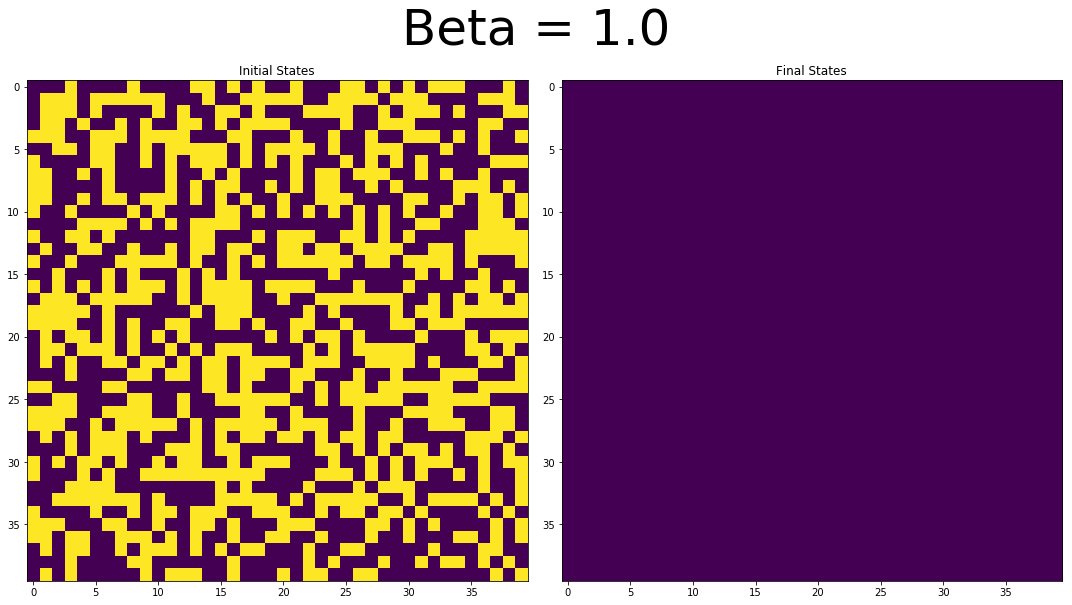

Fraction of dE > 0 accepeted:   0.88%
Magnetisation of the final spin system: 1.0
Run time:   1.59 seconds


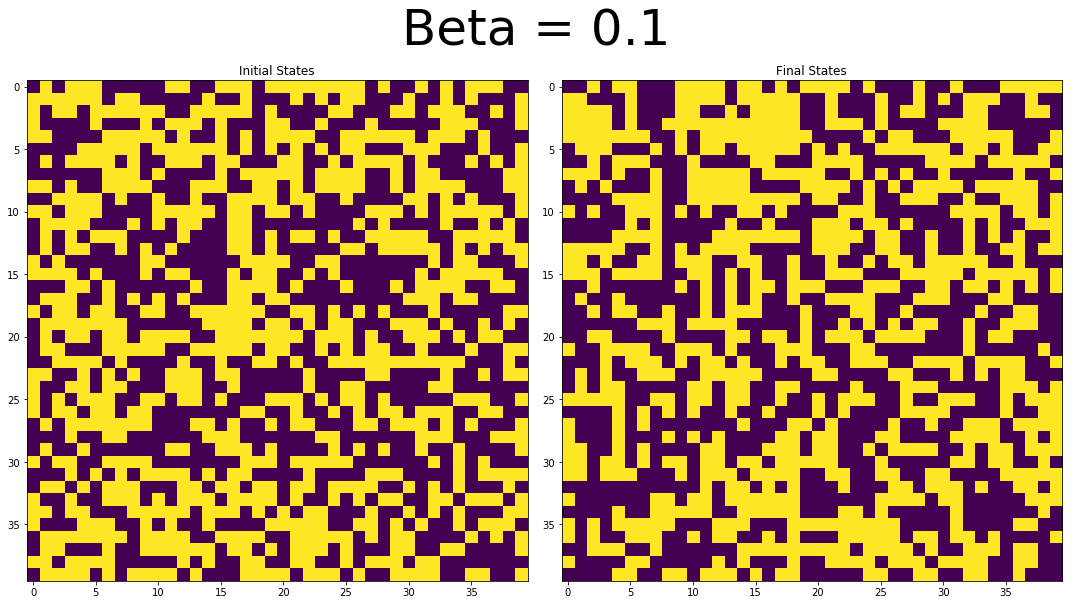

Fraction of dE > 0 accepeted:  60.64%
Magnetisation of the final spin system: 0.0025
Run time:   1.52 seconds


In [6]:
# =============================================================================
# Run some simulations!
# =============================================================================

# J is the strength of the exchange interaction. Use J > 0 for ferromagnetic
# ordering or use J < 0 for anti-ferromagnetic ordering.
J = 1.0
n_steps = 2000000
length = 40

# beta = 1.0 ==================================================================
start = timeit.default_timer()
beta = 1.0

spin_lattice = initialise_spins(length)

# Check that the spin lattice is set up correctly
assert(np.all(np.logical_and(np.any(spin_lattice == -1), 
                             np.any(spin_lattice == 1)))), \
    'Spin lattice not a lattice of ups and downs.'
    
assert(spin_lattice.shape[0] == spin_lattice.shape[1]), \
        'The lattice is not square.'

int_spins = spin_lattice.copy()
energy_array, accepeted, final_spins = monte_carlo(spin_lattice, beta,
                                                   n_steps, J)
magnetisation = average_magnetisation(final_spins)
plot_states(int_spins, final_spins, beta)
stop = timeit.default_timer()

print('Fraction of dE > 0 accepeted: {:6.2f}%'.format(accepeted))
print('Magnetisation of the final spin system: {}'.format(magnetisation))
print('Run time: {:6.2f} seconds'.format(stop - start))

# beta = 0.1 ==================================================================
start = timeit.default_timer()
beta = 0.1

spin_lattice = initialise_spins(length)

# Check that the spin lattice is set up correctly
assert(np.all(np.logical_and(np.any(spin_lattice == -1), 
                             np.any(spin_lattice == 1)))), \
    'Spin lattice not a lattice of ups and downs.'
    
assert(spin_lattice.shape[0] == spin_lattice.shape[1]), \
        'The lattice is not square.'

int_spins = spin_lattice.copy()
energy_array, accepeted, final_spins = monte_carlo(spin_lattice, beta,
                                                   n_steps, J)
magnetisation = average_magnetisation(final_spins)
plot_states(int_spins, final_spins, beta)
stop = timeit.default_timer()

print('Fraction of dE > 0 accepeted: {:6.2f}%'.format(accepeted))
print('Magnetisation of the final spin system: {}'.format(magnetisation))
print('Run time: {:6.2f} seconds'.format(stop - start))


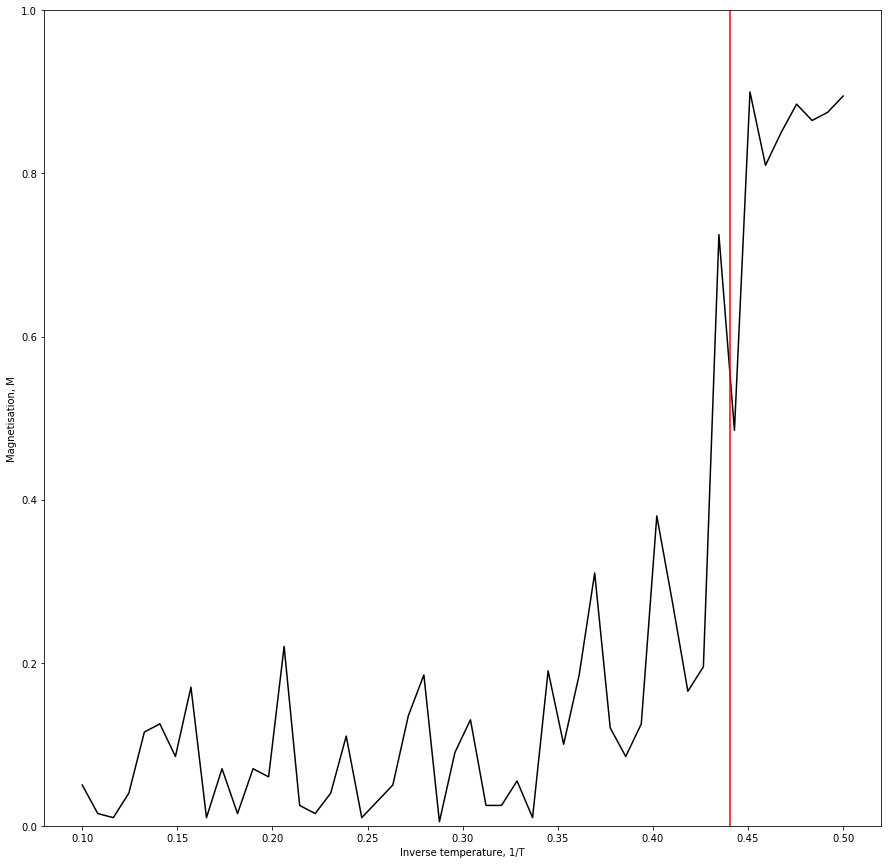

Run time:   5.46 seconds


In [7]:
J = 1.0
n_steps = 500000
length = 20

# magnetisation as a function of beta, use a smaller system ===================
start = timeit.default_timer()
betas = np.linspace(0.1, 0.5, 50)

magnetisation_array = np.zeros((50, 2))
spins = initialise_spins(length)

# Check that the spin lattice is set up correctly
assert(np.all(np.logical_and(np.any(spins == -1), 
                             np.any(spins == 1)))), \
    'Spin lattice not a lattice of ups and downs.'
    
assert(spins.shape[0] == spins.shape[1]), \
        'The lattice is not square.'

n = 0
for beta in betas:

    spin_lattice = spins.copy()
    energy_array, accepeted, final_spins = monte_carlo(spin_lattice, beta,
                                                       n_steps, J)
    magnetisation = average_magnetisation(final_spins)

    magnetisation_array[n][0] = beta
    magnetisation_array[n][1] = magnetisation
    n += 1

plot_magnetisations(magnetisation_array)
stop = timeit.default_timer()

print('Run time: {:6.2f} seconds'.format(stop - start))

The graph above shows that the magnetisation of the system is linked to the beta value of the system. When beta is equal, or as above, near the value of the critcal beta value, the magnetisation of the system increases in an almost discontinous way. This corresponds to the phase transition where the system goes from an unordered to an ordered state. An unordered state has a random distribution of up and down spins, hence no net magnetisation. But, an ordered state has most, if not all, the spins pointing in the same direction (in the J > 0 case) and thus there is a net magnetisation.

The magnetisation should be 0 below the critcal value of beta and have a smooth, but steep, curve, up to a magnetisation of 1 after the critical value of beta. This suggests that Monte Carlo methods may not be a good approach to model systems like the above.